Diagnosing why the confidence calculation is going so badly.

It's not the MEG, because that response is matching what I'd expect, despite the maximum firing rates not being ideal.

(16, 400)


c:\tools\anaconda3\lib\site-packages\seaborn\timeseries.py:183: UserWarning: The `tsplot` function is deprecated and will be removed in a future release. Please update your code to use the new `lineplot` function.
  warnings.warn(msg, UserWarning)


(16, 400)
(16, 400)
(16, 400)


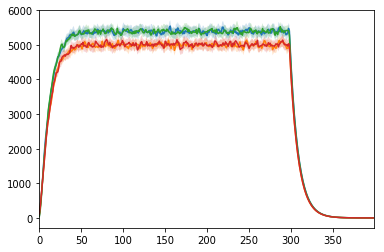

In [36]:
for r_i, resp in enumerate(meg_resp.values()):
    print(resp.shape)
    sns.tsplot(resp, color=f"C{r_i}")

So maybe it's the compare operation acting weird? Nope, it's literally the decoding isn't as good as I thought it was.

In [22]:
from typing import Dict, List
from collections import OrderedDict, namedtuple
import os

import h5py
import numpy as np
import nengo_spa as spa
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nengo_learn_assoc_mem.utils import numpy_bytes_to_str, norm_spa_vecs, BasicVecFeed
from nengo_learn_assoc_mem.paths import data_path

In [17]:
StimSlc = namedtuple("StimSlc", ['strs', 'vecs', 'slc'])

In [54]:
def train_decoders(in_vecs: List[np.ndarray],  n_nrns: int, dims: int,
                   enc: np.ndarray, cepts: np.ndarray, seed: int,
                   t_pres: float, t_paus: float) -> np.ndarray:
    t_each = t_pres + t_paus
    feed = BasicVecFeed(in_vecs, in_vecs, t_pres, dims, len(in_vecs), t_paus)

    with nengo.Network(seed=seed) as learned_model:
        in_nd = nengo.Node(feed.feed)
        correct = nengo.Node(feed.get_answer)
        learning = nengo.Node(lambda t: -feed.paused)
        pause = nengo.Node(lambda t: feed.paused)
        output = nengo.Node(size_in=dims)

        ens = nengo.Ensemble(n_nrns, dims,
                             encoders=enc, intercepts=cepts, seed=seed)

        nengo.Connection(in_nd, ens, synapse=None)
        conn_out = nengo.Connection(ens.neurons, output, transform=np.zeros((dims, n_nrns)),
                                    learning_rule_type=nengo.PES(3.5e-2))
        nengo.Connection(pause, ens.neurons, transform=-10 * np.ones((n_nrns, 1)), synapse=None)

        # Error flow node
        pes_learn_control = nengo.Node(
            lambda t, x: x[:-1] if x[-1] >= 0 else x[:-1] * 0,
            size_in=dims + 1)
        nengo.Connection(pes_learn_control,
                         conn_out.learning_rule)

        # Error calculation connections
        nengo.Connection(output, pes_learn_control[:-1],
                         synapse=None)
        nengo.Connection(correct, pes_learn_control[:-1],
                         transform=-1, synapse=None)
        # Control connection
        nengo.Connection(learning, pes_learn_control[-1],
                         synapse=None)

        p_in = nengo.Probe(in_nd)
        p_cor = nengo.Probe(correct, synapse=None)
        p_dec = nengo.Probe(conn_out, 'weights', sample_every=0.1)
        p_out = nengo.Probe(output, synapse=0.01)

    with nengo.Simulator(learned_model) as learned_sim:
        learned_sim.run(len(in_vecs) * t_each + t_paus)

    return learned_sim.data[p_dec][-1]

In [51]:
def run_comp(in_vec: np.ndarray, dec: np.ndarray, n_nrns: int, dims: int,
             enc: np.ndarray, cepts: np.ndarray, seed: int,
             t_sim: float) -> np.ndarray:

    with spa.Network(seed=seed) as model:
        in_nd = nengo.Node(lambda t: in_vec)

        # max_rates should be set deterministically via seed
        ens = nengo.Ensemble(n_nrns, dims,
                             encoders=enc,
                             intercepts=cepts, seed=seed)
        cmp = spa.Compare(dims)

        nengo.Connection(in_nd, ens, synapse=None)
        nengo.Connection(ens.neurons, cmp.input_a, synapse=.01, transform=dec)
        nengo.Connection(in_nd, cmp.input_b, synapse=.01)

        p_cmp_out = nengo.Probe(cmp.output, synapse=.01)

    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(t_sim)

    cmp_out = sim.data[p_cmp_out]
    print(f"Final cmp val: {cmp_out[-1]}")
    return cmp_out

In [135]:
def run_integ(cmp_out: List, seed: float, dt=0.001) -> Dict[str, np.ndarray]:
    t_sim = len(cmp_out) * dt

    with spa.Network(seed=seed) as model:
        in_nd = nengo.Node(lambda t: cmp_out[int((t-dt)/dt)])
        cmp_res = nengo.Ensemble(300, 1)

        integ_tau = 0.1
        integ_nrns = 300
        pos_integ = nengo.networks.Integrator(integ_tau, integ_nrns, 1)
        neg_integ = nengo.networks.Integrator(integ_tau, integ_nrns, 1)

        nengo.Connection(in_nd, cmp_res, synapse=None)
        nengo.Connection(cmp_res, pos_integ.input,
                         function=lambda x: x - 0.3)
        nengo.Connection(cmp_res, neg_integ.input,
                         function=lambda x: 1 - x)

        p_pos_out = nengo.Probe(pos_integ.output, synapse=.05)
        p_neg_out = nengo.Probe(neg_integ.output, synapse=.05)

    with nengo.Simulator(model, progress_bar=False) as sim:
        sim.run(t_sim)

    return {"pos": sim.data[p_pos_out], "neg": sim.data[p_neg_out]}

In [121]:
stim_types = ("fan1", "fan2", "foil1", "foil2")
seed_val = 1

In [104]:
read_path = os.path.join(data_path, "mixed_static", f"static_voja_alt_{seed_val}.h5")
stim_strs = []

with h5py.File(read_path, "r") as fi:

    for s_t in stim_types:
        stim_strs.append((s_t, numpy_bytes_to_str(fi[s_t])))

    v_strs = numpy_bytes_to_str(fi['vocab_strings'])
    v_vecs = list(fi['vocab_vectors'])
    dimensions = fi['vocab_vectors'].attrs['dimensions']

    encoders = np.array(fi['encoders'])
    n_neurons = encoders.shape[0]
    intercepts = np.full(n_neurons, fi['encoders'].attrs['intercept'])
    init_seed = fi['encoders'].attrs['seed']

    tm = fi["t_range"]
    dt_sim = tm.attrs["dt"]
    t_pause = tm.attrs["t_pause"]
    t_present = tm.attrs["t_present"]

vocab = spa.Vocabulary(dimensions)
for val, vec in zip(v_strs, v_vecs):
    vocab.add(val, vec)

stim_vecs = OrderedDict((
                ("fan1", None),
                ("fan2", None),
                ("foil1", None),
                ("foil2", None)))
for (nm, strs) in stim_strs:
    stim_vecs[nm] = norm_spa_vecs(vocab, strs)

In [142]:
train_vecs = stim_vecs["fan1"] + stim_vecs["fan2"]
train_res = train_decoders(train_vecs, n_neurons, dimensions,
                           encoders, intercepts, init_seed, 0.5, 0.2)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

In [143]:
feed_vecs = []
for vecs in stim_vecs.values():
    feed_vecs += vecs

In [144]:
all_comp_res = []
final_vals = []
for f_i, f_vec in enumerate(feed_vecs):
    comp_res = run_comp(f_vec, train_res, n_neurons, dimensions,
                        encoders, intercepts, init_seed, 0.2)
    final_vals.append(comp_res[-1])
    all_comp_res.append(comp_res)

Final cmp val: [0.94366284]
Final cmp val: [0.98178663]
Final cmp val: [1.01982056]
Final cmp val: [1.11467341]
Final cmp val: [0.88647564]
Final cmp val: [1.00566381]
Final cmp val: [0.9531551]
Final cmp val: [0.99155603]
Final cmp val: [1.01582219]
Final cmp val: [0.9236884]
Final cmp val: [0.92502485]
Final cmp val: [0.94916812]
Final cmp val: [0.85131576]
Final cmp val: [0.86112338]
Final cmp val: [0.87235913]
Final cmp val: [1.03342098]
Final cmp val: [1.0399121]
Final cmp val: [1.02413323]
Final cmp val: [1.12250212]
Final cmp val: [0.91795523]
Final cmp val: [1.05891788]
Final cmp val: [1.03322615]
Final cmp val: [0.99943688]
Final cmp val: [1.02591138]
Final cmp val: [0.98858888]
Final cmp val: [0.9971198]
Final cmp val: [1.10441599]
Final cmp val: [0.96243745]
Final cmp val: [1.03147281]
Final cmp val: [1.10779482]
Final cmp val: [1.0251736]
Final cmp val: [1.02316432]
Final cmp val: [0.54556899]
Final cmp val: [0.45871272]
Final cmp val: [0.34679688]
Final cmp val: [0.4270459

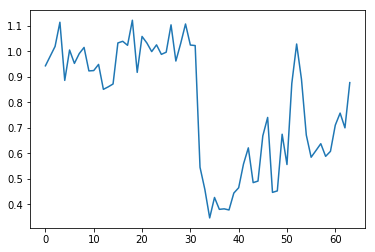

In [145]:
plt.plot(final_vals)

In [146]:
tot_final_vals = [np.sum(x) for x in all_comp_res]

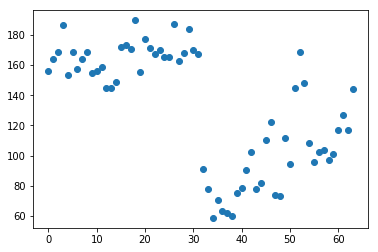

In [147]:
plt.scatter(np.arange(len(tot_final_vals)), tot_final_vals)

In [111]:
train_len = len(train_vecs)

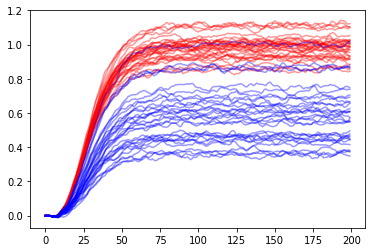

In [112]:
plt.plot(np.array(all_comp_res)[:train_len].squeeze().T, color='r', alpha=0.4);
plt.plot(np.array(all_comp_res)[train_len:].squeeze().T, color='b', alpha=0.4);

In [113]:
min_targ_comp

0.8452085936031106

In [134]:
max_targ_comp = np.max(final_vals[:train_len])
min_foil_comp = np.min(final_vals[train_len:])
print(max_targ_comp)
print(min_foil_comp)

1.1233107359457721
0.34818371182326985


In [136]:
neg_integ_res = []
pos_integ_res = []
for c_i, c_res in enumerate(all_comp_res):
    integ_res = run_integ(list(c_res)[10:125], init_seed)
    neg_integ_res.append(integ_res["neg"])
    pos_integ_res.append(integ_res["pos"])

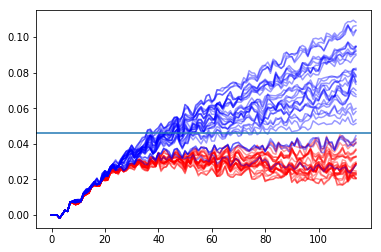

In [148]:
plt.plot(np.array(neg_integ_res[:train_len]).squeeze().T, color='r', alpha=0.4)
plt.plot(np.array(neg_integ_res[train_len:]).squeeze().T, color='b', alpha=0.4);
plt.axhline(0.046)

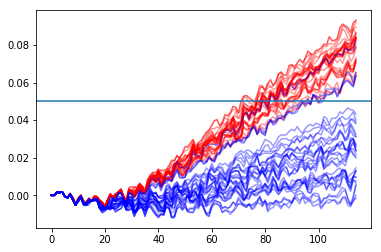

In [139]:
plt.plot(np.array(pos_integ_res[:train_len]).squeeze().T, color='r', alpha=0.4)
plt.plot(np.array(pos_integ_res[train_len:]).squeeze().T, color='b', alpha=0.4);
plt.axhline(0.05)

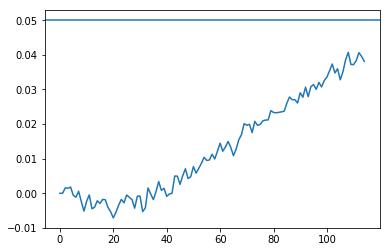

In [154]:
plt.plot(pos_integ_res[-2])
plt.axhline(0.05)

In [156]:
np.where(pos_integ_res[-2] > 0.05)

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
def get_rt(integ_res, thresh: float):
    react_tms = []

    for i_res in integ_res:
        whr = np.where(i_res > 0.05)
        if len(whr[0]) == 0:
            react_tms.append(-1)
        else:
            react_tms.append(whr[0][0])